# Algotrading 

In [43]:
%load_ext autoreload
%autoreload 2
import pandas as pd

from surfingcrypto import Config,TS
from surfingcrypto.algotrading.backtesting import BackTest
from surfingcrypto.algotrading.features import BinaryLaggedFeatures
from surfingcrypto.algotrading.model import Model


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
coins={
    "BTC":"",
    "ETH":"",
    "MATIC":"",
    "ADA":"",
    "SOL":""
}
c = Config(coins,"/Users/giorgiocaizzi/Documents/GitHub/surfingcrypto/config")


In [45]:
ticker = "ETH"
ts = TS(c, coin=ticker)
ts.ta_indicators()
ts.df


,Open,High,Low,Close,Volume,Market Cap,SMA_26,SMA_12,SMA_200,SMA_100,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,RSI_14
Date,,,,,,,,,,,,,,,,,,,
2017-10-01 00:00:00+00:00,255.288687,256.747390,249.797667,256.044212,2.593030e+08,2.430109e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-02 00:00:00+00:00,256.167001,256.711876,250.857533,253.580263,2.893556e+08,2.407106e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-03 00:00:00+00:00,253.587078,256.395551,245.386642,248.989454,2.738634e+08,2.363906e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-04 00:00:00+00:00,249.237185,254.456920,247.380720,248.964687,2.194011e+08,2.364053e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-05 00:00:00+00:00,249.062535,254.518348,245.716713,252.593705,2.166371e+08,2.398902e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-03 00:00:00+00:00,2718.546125,2719.287351,2624.402083,2644.522293,1.237582e+10,3.190207e+11,2779.255242,2705.388898,3065.386466,2637.347949,-46.651521,-10.479006,-36.172515,2598.419611,2748.694399,2898.969187,10.934267,0.153395,43.912431
2022-05-04 00:00:00+00:00,2644.194517,2789.713909,2639.987546,2768.699442,1.712333e+10,3.340372e+11,2772.865437,2707.063499,3062.719273,2643.484266,-38.553583,-1.904854,-36.648728,2598.245007,2747.603512,2896.962017,10.871911,0.570622,50.476643
2022-05-05 00:00:00+00:00,2768.305714,2776.983095,2567.971679,2608.436839,2.148347e+10,3.147363e+11,2757.841926,2697.447281,3059.174146,2647.840879,-44.554169,-6.324352,-38.229816,2579.534020,2737.397103,2895.260186,11.533809,0.091544,43.414647


## Feature Engineering

The chosen algo uses binary encoding for upward or downward movements.

In [46]:
f = BinaryLaggedFeatures(
    ts,
    indicators=[
        "SMA_12_26_Signal",
        "SMA_100_200_Signal",
        "MACD_12_26_9_Signal",
        "BBL_20_2_Signal",
        "RSI_14_Signal",
    ],
    lags=[1, 2, 3, 7, 14],
)
f


BinaryLaggedFeatures(ts=ETH,lags=[1, 2, 3, 7, 14])

In [47]:
f.indicators

{'i_01': 'SMA_12_26_Signal',
 'i_02': 'SMA_100_200_Signal',
 'i_03': 'MACD_12_26_9_Signal',
 'i_04': 'BBL_20_2_Signal',
 'i_05': 'RSI_14_Signal'}

### Signals

- SMA Cross
- MACD
- Bollinger Bands
- RSI

In [48]:
f.df.tail()


,Open,High,Low,Close,Volume,Market Cap,SMA_26,SMA_12,SMA_200,SMA_100,...,RSI_14,SMA_12_26_Signal,SMA_100_200_Signal,MACD_12_26_9_Signal,PREV_STOCK,PREV_LOWERBB,PREV_UPPERBB,BBL_20_2_Signal,PREV_RSI,RSI_14_Signal
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-03 00:00:00+00:00,2718.546125,2719.287351,2624.402083,2644.522293,1.237582e+10,3.190207e+11,2779.255242,2705.388898,3065.386466,2637.347949,...,43.912431,0.0,0.0,0.0,2718.791819,2609.535515,2909.612671,1.0,47.401841,0.0
2022-05-04 00:00:00+00:00,2644.194517,2789.713909,2639.987546,2768.699442,1.712333e+10,3.340372e+11,2772.865437,2707.063499,3062.719273,2643.484266,...,50.476643,0.0,0.0,0.0,2644.522293,2598.419611,2898.969187,1.0,43.912431,0.0
2022-05-05 00:00:00+00:00,2768.305714,2776.983095,2567.971679,2608.436839,2.148347e+10,3.147363e+11,2757.841926,2697.447281,3059.174146,2647.840879,...,43.414647,0.0,0.0,0.0,2768.699442,2598.245007,2896.962017,1.0,50.476643,0.0
2022-05-06 00:00:00+00:00,2608.169786,2617.175690,2502.838952,2554.894640,1.993458e+10,3.083096e+11,2742.609982,2685.034888,3055.808933,2651.434204,...,41.334024,0.0,0.0,0.0,2608.436839,2579.534020,2895.260186,1.0,43.414647,0.0
2022-05-07 00:00:00+00:00,2554.906169,2556.480786,2464.400161,2499.068846,1.267434e+10,3.016059e+11,2733.316629,2659.199180,3051.638385,2654.683205,...,39.223332,0.0,0.0,0.0,2554.894640,2553.203766,2893.844674,1.0,41.334024,0.0


### Model dataframe

In [49]:
f.model_df.tail()

,ETH,i_01,i_02,i_03,i_04,i_05,returns,direction,i_01_lag01,i_01_lag02,...,i_04_lag01,i_04_lag02,i_04_lag03,i_04_lag07,i_04_lag14,i_05_lag01,i_05_lag02,i_05_lag03,i_05_lag07,i_05_lag14
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-03 00:00:00+00:00,2644.522293,0.0,0.0,0.0,1.0,0.0,-0.027697,-1,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2022-05-04 00:00:00+00:00,2768.699442,0.0,0.0,0.0,1.0,0.0,0.045887,1,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2022-05-05 00:00:00+00:00,2608.436839,0.0,0.0,0.0,1.0,0.0,-0.059627,-1,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2022-05-06 00:00:00+00:00,2554.894640,0.0,0.0,0.0,1.0,0.0,-0.020740,-1,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2022-05-07 00:00:00+00:00,2499.068846,0.0,0.0,0.0,1.0,0.0,-0.022093,-1,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


### Build and Apply Classification Machine Learning Algorithms

Select Logistic regression, Gaussian Naive Bayes, Support Vector Machine, Random Forest, and MLP Classifier approaches to predict the market direction. Please refer sklearn documentation for detail on these and other algorithms.
https://scikit-learn.org/stable/index.html

In [50]:
models = [
    "log_reg",
    "gauss_nb",
    "svm",
    "random_forest",
    "MLP",
]
models=[Model(x,f) for x in models]

### Strategy evalutation using Backtrader

Strategy: 
1.	Buy when the predicted value is +1 and sell (only if stock is in possession) when the predicted value is -1.
2.	All-in strategy—when creating a buy order, buy as many shares as possible.
3.	Short selling is not allowed

In [51]:
start = "2021-01-01"

performance = {}
backtests = {}
for model in models:
    # run
    i_backtest = BackTest(model,start, verbose=False)
    i_backtest.run()
    backtests[model.name] = i_backtest
    performance[model.name] = i_backtest.performance_stats()
performance = pd.DataFrame(performance)



In [52]:
performance


,log_reg,gauss_nb,svm,random_forest,MLP
Annual return,2.515465,2.520848,4.186378,0.658207,1.576864
Cumulative returns,10.640358,10.675182,23.870649,1.684221,5.347566
Annual volatility,0.603703,0.744496,0.623308,0.614671,0.610674
Sharpe ratio,2.383887,2.066107,2.954419,1.126932,1.852641
Calmar ratio,10.905515,5.087899,15.366403,1.266637,4.658347
Stability,0.934566,0.931705,0.904402,0.397970,0.806612
Max drawdown,-0.230660,-0.495459,-0.272437,-0.519649,-0.338503
Omega ratio,1.673742,1.516160,1.849788,1.280678,1.488048
Sortino ratio,4.222971,3.301676,5.366828,1.822928,3.162859
Skew,0.677171,0.129097,0.683755,0.574562,0.706227


## Choose best model from backtesting results

Choose the one with the greates cumulative returns.

In [53]:
best_model=[x for x in models if x.name==performance.loc["Cumulative returns"].idxmax()][0]
backtest = backtests[performance.loc["Cumulative returns"].idxmax()]

best_model


Model(name=svm)

In [54]:
backtest.end_value


31088.311718931134

In [55]:
backtest.print_log()


2021-01-02, Open: 600.888, Close: 638.266
2021-01-02,     BUY CREATED --- Size: 2.060, Price: 600.860, Cost: 1237.500
2021-01-02,     BUY EXECUTED --- Size: 2.060, Price: 600.888, Cost: 1237.559, Commission: 12.376
2021-02-07, Open: 1392.314, Close: 1339.759
2021-02-07,     SELL CREATED --- Size: -2.060, Price: 1392.514, Cost: -2867.951
2021-02-07,     SELL EXECUTED --- Size: -2.060, Price: 1392.314, Cost: -2867.539, Commission: 28.675
2021-02-07,          -> OPERATION RESULT --- Gross: 1629.980, Net: 1588.929
2021-02-28, Open: 1209.284, Close: 1171.184
2021-02-28,     BUY CREATED --- Size: 2.324, Price: 1209.377, Cost: 2810.539
2021-02-28,     BUY EXECUTED --- Size: 2.324, Price: 1209.284, Cost: 2810.323, Commission: 28.103
2021-05-13, Open: 3170.256, Close: 3076.269
2021-05-13,     SELL CREATED --- Size: -2.324, Price: 3134.596, Cost: -7284.661
2021-05-13,     SELL EXECUTED --- Size: -2.324, Price: 3170.256, Cost: -7367.535, Commission: 73.675
2021-05-13,          -> OPERATION RESULT

# Plotting

In [56]:
backtest.plot_timeline()


[[<Figure size 2160x720 with 4 Axes>, <Figure size 2160x720 with 4 Axes>]]

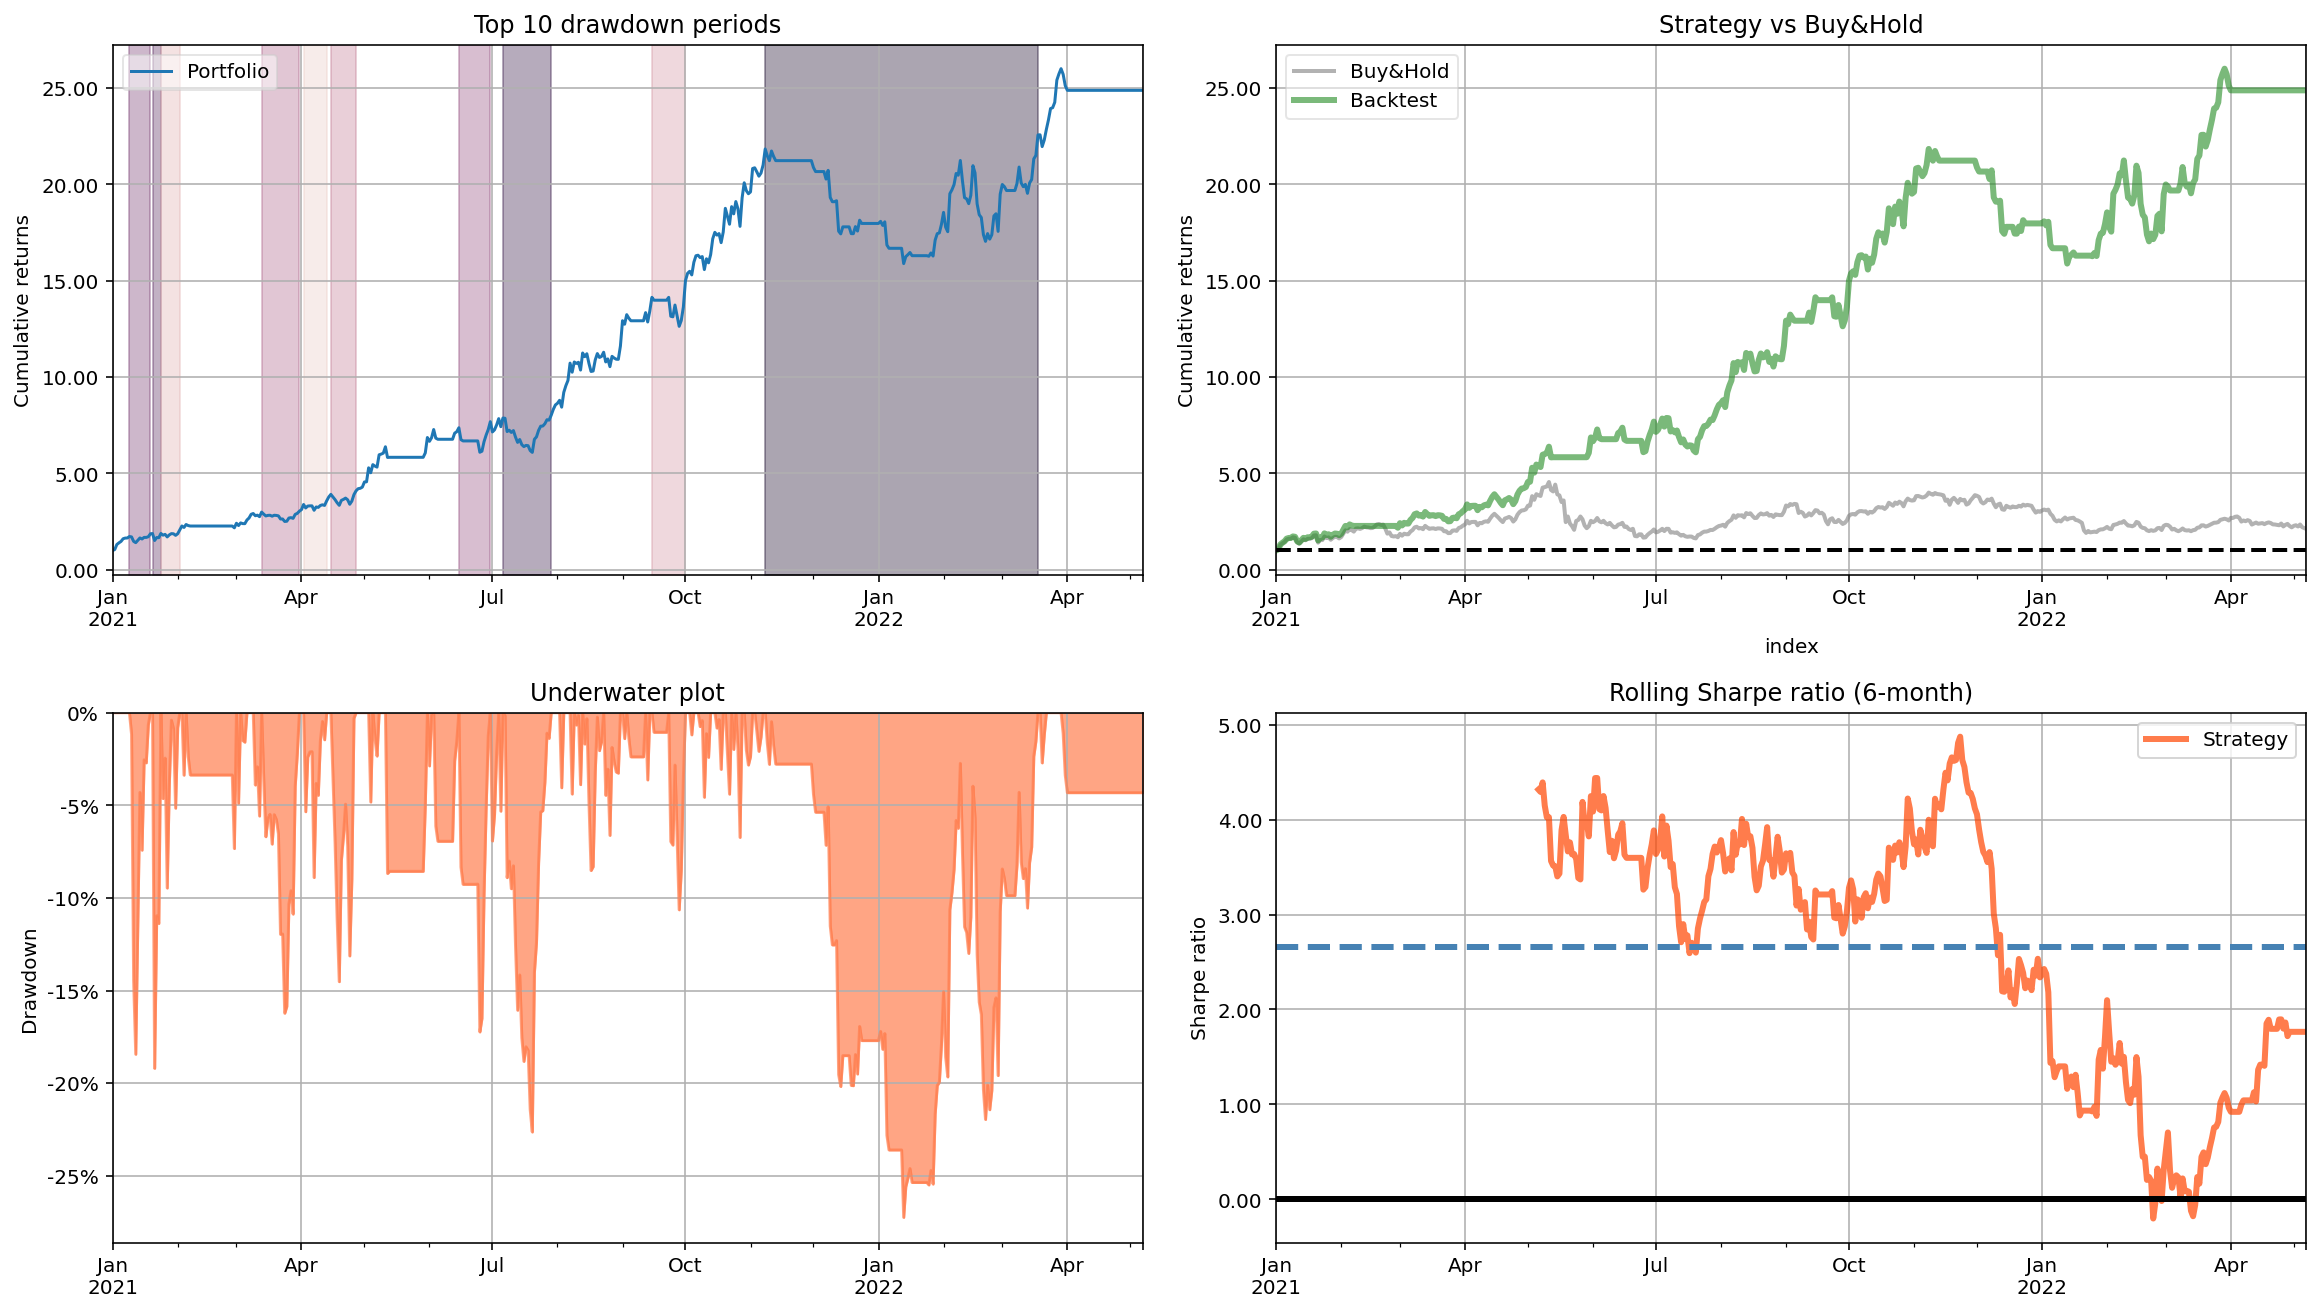

In [57]:
backtest.plot_performance()

# Apply to future

In [58]:
best_model.make_tomorrow_prediction()

SELL / STAY OUT OF MARKET


/opt/miniconda3/envs/cryptoenv/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


-1